In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

In [2]:
yy = yy.reshape(-1,8,11)
xx = np.repeat(xx, 8*11,axis=0)

def append_and_expand(a,x,y):
    # use choose and where !
    n = len(x)*len(y)
    a_index = np.arange(len(a))%n
    
    
    x_index = a_index//len(y)
    y_index = a_index%len(y)
    
    x_added = np.choose(x_index,x.reshape(-1,1)).reshape(-1,1)
    y_added = np.choose(y_index,y.reshape(-1,1)).reshape(-1,1)
    
    return np.hstack([a,x_added,y_added])

In [3]:
xx_pointwise=append_and_expand(xx,maturities,strikes)
yy_pointwise = yy.reshape(-1)

xx = xx_pointwise
yy = yy_pointwise.reshape(-1,1)

In [4]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

scale_y=  StandardScaler()

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5,2.0,1.5])
lb=np.array([0.01,0.3,-0.95,0.025,0.1,0.5])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =64,shuffle=True)

device is cpu


In [5]:
print(x_test_transform.shape,y_test_transform.shape)

(528000, 6) (528000, 1)


In [6]:
import numpy as np
import pandas as pd
import torch 
import scipy
import time

import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cpu')
tensor_dtype = torch.float64

# Set the derivatives dynamic model's parameter's nums here !
Paranums = 4

hyperparas = {'input_dim':6,'hidden_dim':32,'hidden_nums':20,'output_dim':1,'block_layer_nums':2}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=tensor_dtype)

model_state = torch.load('../../Data/YU/rflatBergomi_pointwise.pth')

model.load_state_dict(model_state)

model.eval()


model.to(device=device,dtype=tensor_dtype)

ResNN_pricing(
  (linear_stock): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6, out_features=32, bias=True)
      (1): ReLU()
    )
    (1): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (2): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (3): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (4): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (layernorms): Modul

In [7]:
error =(model(test_data[0][:8800,:])-test_data[1][:8800]).detach().numpy()

print(np.mean(error**2))

0.0004555852688514265


In [8]:
test_sample_nums = 880

theta_transform = x_test_transform[:test_sample_nums,:4]
T_K_transform = x_test_transform[:test_sample_nums,4:]
y_test_transform = y_test_transform[:test_sample_nums]

In [9]:
# Upper and lower bounds used in the training set
ub_theta=ub[:4]
lb_theta=lb[:4]

def mythetascale(x):
    return (x - (ub_theta+lb_theta)*0.5)*2/(ub_theta-lb_theta)
def mythetainverse(x):
    return x*(ub_theta-lb_theta)*0.5+(ub_theta+lb_theta)*0.5

In [10]:
def CostFunc(theta,T_K,sample_ind):
    return np.sum(np.power((model(torch.from_numpy(np.concatenate([theta,T_K]))).detach().numpy()
                            -y_test_transform[sample_ind]),2))

In [11]:
import time
import scipy
Approx=[]
Timing=[]
solutions=np.zeros([3,4])
times=np.zeros(3)
init=np.zeros(4)
for i in range(test_sample_nums):
    disp=str(i+1)+f"/{test_sample_nums}"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=(T_K_transform[i,:],i),method='L-BFGS-B',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[0,:]=mythetainverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=(T_K_transform[i,:],i),method='SLSQP',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[1,:]=mythetainverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=(T_K_transform[i,:],i),method='BFGS',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[2,:]=mythetainverse(I.x)
    times[2]=end-start
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))

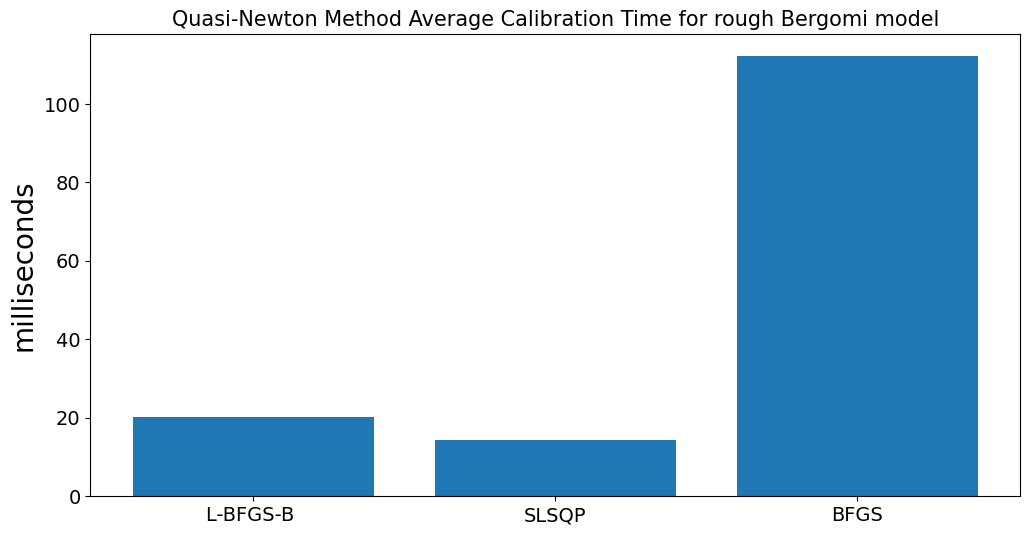

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

methods=["L-BFGS-B ","SLSQP","BFGS"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
plt.title("Quasi-Newton Method Average Calibration Time for rough Bergomi model",fontsize=15)
plt.ylabel("milliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

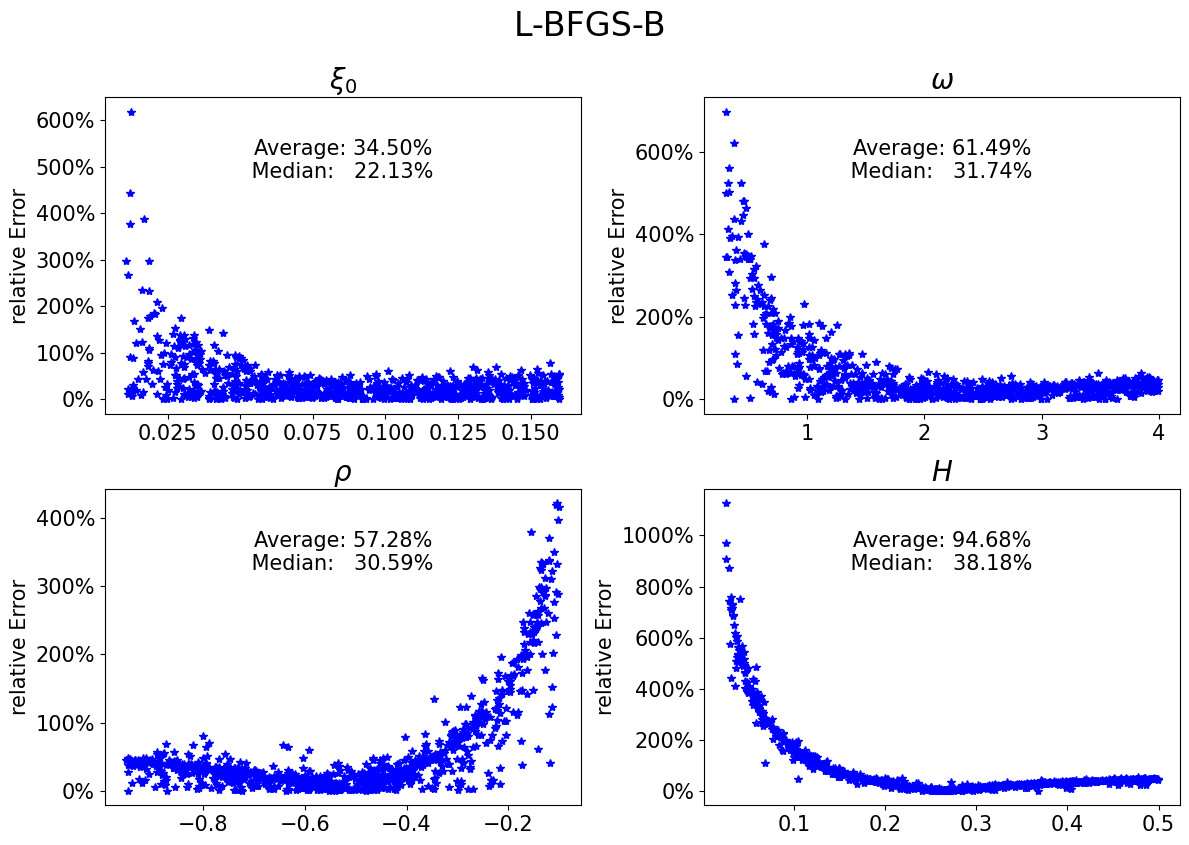

In [ ]:
LMParameters=[Approx[i][0] for i in range(len(Approx))]
np.savetxt(f"../../Data/YU/NNParametersrbergomipointwise_cali{methods[0]}.txt",LMParameters)
LMParameters = np.loadtxt(f"../../Data/YU/NNParametersrbergomipointwise_cali{methods[0]}.txt")

titles=["$\\xi_0$","$\\omega$","$\\rho$","$H$"]
average=np.zeros([4,test_sample_nums])
fig=plt.figure(figsize=(12,8))
for u in range(4):
    ax=plt.subplot(2,2,u+1)
    x=x_test[:test_sample_nums,u]
    plt.plot(x,100*np.abs(LMParameters[:test_sample_nums,u]-x)/np.abs(x),'b*')
    average[u,:]=np.abs(LMParameters[:test_sample_nums,u]-x)/np.abs(x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()
plt.suptitle(f"{methods[0]}", fontsize=24, y=1.05)
plt.savefig('rBergomiParameterRelativeErrors_pointwise.png', dpi=300)
plt.show();

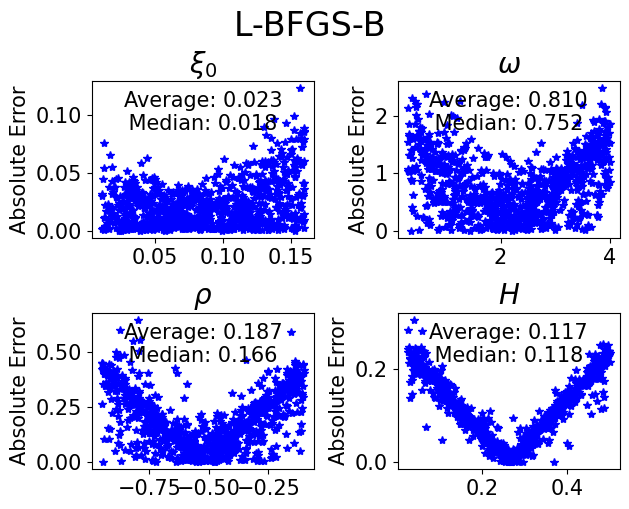

In [ ]:
for u in range(4):
    ax=plt.subplot(2,2,u+1)
    x=x_test[:test_sample_nums,u]
    plt.plot(x,np.abs(LMParameters[:test_sample_nums,u]-x),'b*')
    average[u,:]=np.abs(LMParameters[:test_sample_nums,u]-x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('Absolute Error',fontsize=15)
    
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, f'Average: {np.mean(average[u,:]):.3f}\n Median: {np.median(average[u,:]):.3f} ',
              horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()
plt.suptitle(f"{methods[0]}", fontsize=24, y=1.05)
plt.savefig('rBergomiParameterRelativeErrors_simple.png', dpi=300)
plt.show();